# **Generación Automatica de Resúmes con ML-NLP**

## **Tabla de Contenido**

## 1. Introducción
## 2. Configuración e Instalación
## 3. Entendimiento de los Datos
## 4. Preprocesamiento de los Datos
## 5. Preparación de Datos y Modelado
## 6. Model Inference
## 7. Conclusiones y Observaciones

## **1. Introducción**

### **1.1. Integrantes**

* Juan Carlos Peralta Olivera juancarlosperaltaolivera@gmail.com

### **1.2. Objetivo Principal**

El objetivo del proyecto es utilizar técnicas de Natural Language Processing (NLP) y Machine Learning (ML) para generar resúmenes de noticias en inglés de manera automática y evaluar la calidad de dichos resúmenes.

### **1.3. Objetivos Específicos**

* Crear un modelo basado en una arquitectura de red neuronal recurrente bidireccional (Bidirectional LSTM).
* Utilizar el dataset *BBC News* para entrenar el modelo propuesto.
* Aplicar funciones de Natural Language Processing (NPL) o Procesamiento del Lenguaje Natural para procesar las noticias y sus correspondientes resúmenes del dataset.
* Usar funciones de generación y evaluación de los resúmenes generados automáticamente que aplican el modelo entrenado.
* Probar la efectividad del generador se usa el dataset de noticias *English Dataset.csv*, del cual se extraen 25 noticias al azar.

## **2. Configuración e Instalación**

In [ ]:
# Instalar librerías necesarias
!pip install -q tensorflow
!pip install -q nltk
!pip install -q sentencepiece
!pip install -q rouge

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.7 MB/s eta 0:00:00


In [ ]:
# Librerías de manipulación y análisis de datos
import pandas as pd
import numpy as np

# Librerías de visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías de aprendizaje automático
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector, TimeDistributed, Bidirectional, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

# Librerías de procesamiento del lenguaje natural (NLP)
import nltk
from nltk import pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

# Librería de evaluación de resúmenes
import random
import math
from rouge import Rouge

In [ ]:
# Carga del modelo Universal Sentence Encoder de Google
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

In [ ]:
# Carga del dataset BBC News
filename = 'bbc-news-data.csv'
lines = []

# Leer el archivo CSV línea por línea
with open(filename, 'r') as file:
    for line in file:
        # Eliminar los saltos de línea y dividir la línea en campos
        fields = line.strip().split('\t')
        if len(fields) != 5:
            # Si la línea no tiene el número correcto de campos, imprimir la línea y continuar
            print(f'Error en la línea: {line}')
            continue
        lines.append(fields)

# Convertir la lista de líneas en un DataFrame de Pandas
data = pd.DataFrame(lines, columns=['category', 'filename', 'title', 'content', 'summary'])

In [ ]:
# Se añaden dos columnas más

# Número de palabras por noticia (content)
data['content_len'] = data['content'].apply(lambda x: len(x.split()))

# Número de palabras por resumen (summary)
data['summary_len'] = data['summary'].apply(lambda x: len(x.split()))


## **3. Entendimiento de los Datos**


BBC News es una organización de noticias británica que produce contenido en diferentes formatos, incluyendo texto, audio y video. El dataset BBC News es un conjunto de datos que consiste en 2225 artículos de noticias de BBC News, publicados entre agosto 1998 y agosto 2005, que abarcan diferentes temas como política, tecnología, entretenimiento, deportes y negocios.

Cada artículo en el conjunto de datos tiene un campo de "categoría" que indica la sección de noticias a la que pertenece. Hay cinco categorías diferentes en el conjunto de datos: deportes, negocios, tecnología, entretenimiento y política. La distribución de los artículos en el conjunto de datos es la siguiente:

Deportes: 511 artículos
Negocios: 510 artículos
Tecnología: 401 artículos
Entretenimiento: 386 artículos
Política: 417 artículos

En este caso específico se usará la versión disponible en https://www.kaggle.com/datasets/hgultekin/bbcnewsarchive que corresponde a un archivo de texto tipo csv separado por tabulaciones. Tiene 5 columnas, la primera fila es la cabecera e indica el nombre de cada columna:
* category: indica la categoría de la noticia
* filename: nombre del archivo en que estaba la noticia originalmente, 
* title: es el título de la noticia.
* content: es la noticia completa.
* summary: es el resumen de la noticia.

Los datos en bruto se pueden descargar de https://www.kaggle.com/datasets/pariza/bbc-news-summary



### **3.1. Análisis Exploratorio de Datos (EDA)**

In [ ]:
# información del dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226 entries, 0 to 2225
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     2226 non-null   object
 1   filename     2226 non-null   object
 2   title        2226 non-null   object
 3   content      2226 non-null   object
 4   summary      2226 non-null   object
 5   content_len  2226 non-null   int64 
 6   summary_len  2226 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 121.9+ KB
None


In [ ]:
# Estadísticas básicas del dataset
print(data.describe())

       content_len  summary_len
count  2226.000000  2226.000000
mean    378.666217   165.092992
std     238.301817   108.687263
min       1.000000     1.000000
25%     240.000000   103.000000
50%     326.000000   142.000000
75%     466.000000   202.000000
max    4428.000000  2073.000000


In [ ]:
# Ver las categorías de noticias
print(data['category'].unique())

['category' 'business' 'entertainment' 'politics' 'sport' 'tech']


In [ ]:
# Número de noticias en cada categoría
print(data['category'].value_counts())

sport            511
business         510
politics         417
tech             401
entertainment    386
category           1
Name: category, dtype: int64


In [ ]:
# Muestra de algunas noticias
display(data)

,category,filename,title,content,summary,content_len,summary_len
0,category,filename,title,content,summary,1,1
1,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,TimeWarner said fourth quarter sales rose 2% t...,415,134
2,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,The dollar has hit its highest level against t...,379,158
3,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,Yukos' owner Menatep Group says it will ask Ro...,258,121
4,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,"Rod Eddington, BA's chief executive, said the ...",400,197
...,...,...,...,...,...,...,...
2221,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...,BT is introducing two initiatives to help beat...,414,186
2222,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...,A third of them read unsolicited junk e-mail a...,352,130
2223,tech,399.txt,Be careful how you code,A new European directive could put software w...,This goes to the heart of the European project...,1045,475
2224,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...,Amit Yoran was director of the National Cyber ...,374,137


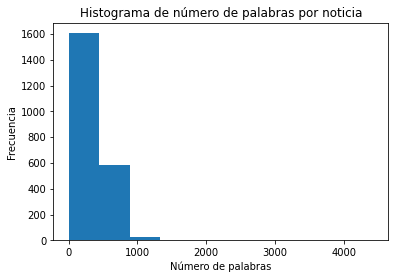

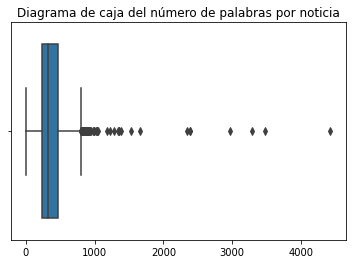

In [ ]:
# Número de palabras por noticia (content)

# Histograma
plt.hist(data['content_len'])
plt.title('Histograma de número de palabras por noticia')
plt.xlabel('Número de palabras')
plt.ylabel('Frecuencia')
plt.show()

# Gráfica de cajas
sns.boxplot(x=[len(x.split()) for x in data['content']])
plt.title('Diagrama de caja del número de palabras por noticia')
plt.show()

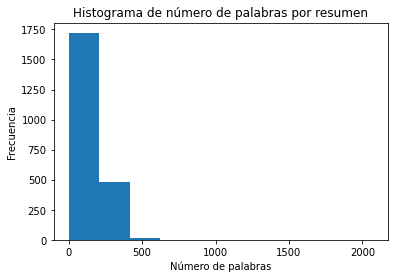

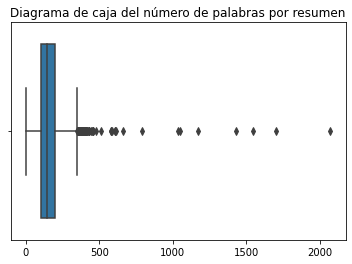

In [ ]:
# Número de palabras por resumen (summary)

# Histograma
plt.hist(data['summary_len'])
plt.title('Histograma de número de palabras por resumen')
plt.xlabel('Número de palabras')
plt.ylabel('Frecuencia')
plt.show()

# Gráfica de cajas
sns.boxplot(x=[len(x.split()) for x in data['summary']])
plt.title('Diagrama de caja del número de palabras por resumen')
plt.show()

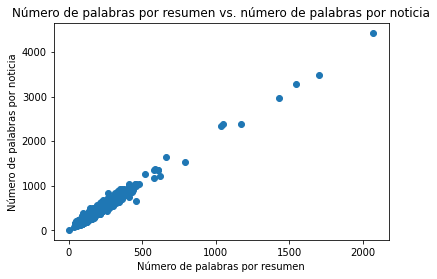

In [ ]:
# Generar gráfico de dispersión
plt.scatter(data['summary_len'], data['content_len'])
plt.title('Número de palabras por resumen vs. número de palabras por noticia')
plt.xlabel('Número de palabras por resumen')
plt.ylabel('Número de palabras por noticia')
plt.show()

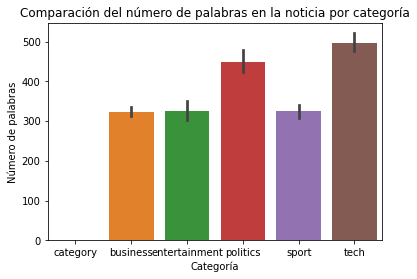

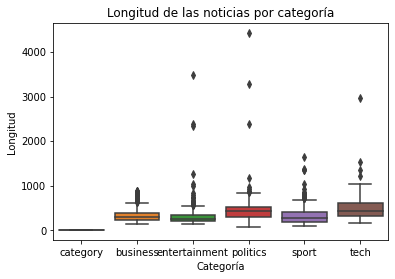

In [ ]:
# Crear la gráfica de barras para el número de palabras por noticia por categoría
sns.barplot(x='category', y='content_len', data=data)
plt.title('Comparación del número de palabras en la noticia por categoría')
plt.xlabel('Categoría')
plt.ylabel('Número de palabras')
plt.show()

# Diagrama de cajas
sns.boxplot(x='category', y='content_len', data=data)
plt.title('Longitud de las noticias por categoría')
plt.xlabel('Categoría')
plt.ylabel('Longitud')
plt.show()

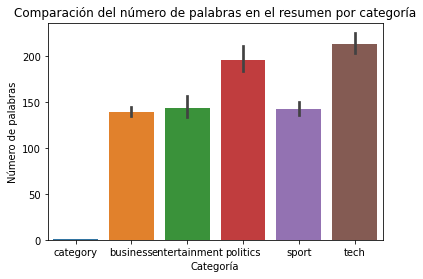

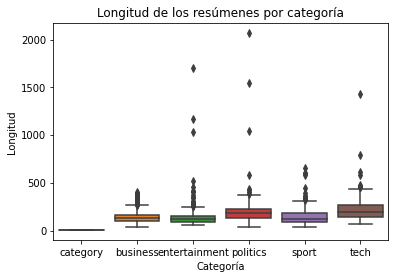

In [ ]:
# Gráfica de barras para el número de palabras por resumen por categoría
sns.barplot(x='category', y='summary_len', data=data)
plt.title('Comparación del número de palabras en el resumen por categoría')
plt.xlabel('Categoría')
plt.ylabel('Número de palabras')
plt.show()

# Diagrama de cajas
sns.boxplot(x='category', y='summary_len', data=data)
plt.title('Longitud de los resúmenes por categoría')
plt.xlabel('Categoría')
plt.ylabel('Longitud')
plt.show()

## **4. Preprocesamiento de los Datos**

### **4.1 Definición de Funciones**

In [ ]:
# Función de tokenización
def tokenize_text(text):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text)
    return tokenizer

In [ ]:
stop_words = set(stopwords.words('english'))

# Función de eliminación de stopwords
def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if not word.lower() in stop_words]
    return " ".join(filtered_tokens)

In [ ]:
# Función de lematización
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = []
    for word, tag in pos_tag(word_tokenize(text)):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_text.append(lemmatizer.lemmatize(word, pos))
    return " ".join(lemmatized_text)

In [ ]:
# Función de extracción pos tags
def pos_tag_text(text):
    return pos_tag(word_tokenize(text))

In [ ]:
# Función de selección de frase importantes
def important_sentences(text, embed, top_n=3):
    sentences = text.split('.')
    sentence_embeddings = embed(sentences)
    rankings = np.argsort(np.sum(sentence_embeddings, axis=1))
    return '. '.join([sentences[i] for i in rankings[-top_n:]])

### **4.2. Aplicación de NLP al Texto** 

**Noticias**

In [ ]:
# Eliminación de STOPWORDS
data['content_stopwords_removed'] = data['content'].apply(lambda x: remove_stopwords(x))

In [ ]:
# Lematizar la columna 'content_stopwords_removed'
data['content_lemmatized'] = data['content_stopwords_removed'].apply(lambda x: lemmatize_text(x))

In [ ]:
# Crear la columna 'summary_len' con la longitud del resumen en palabras
data['content_lemmatized_len'] = data['content_lemmatized'].apply(lambda x: len(x.split()))

In [ ]:
# Pos Tags
data['content_pos'] = data['content'].apply(pos_tag_text)

In [ ]:
# Extracción de frases relevantes
data['important_sentences'] = data['content'].apply(lambda x: important_sentences(x, embed, 3))

**Resúmenes**

In [ ]:
# Eliminación de STOPWORDS
data['summary_stopwords_removed'] = data['summary'].apply(remove_stopwords)

In [ ]:
# Lematizar la columna 'summary_stopwords_removed'
data['summary_lemmatized'] = data['summary_stopwords_removed'].apply(lemmatize_text)

In [ ]:
# Crear la columna 'summary_lemmatized_len' con la longitud del resumen en palabras
data['summary_lemmatized_len'] = data['summary_lemmatized'].apply(lambda x: len(x.split()))

### **4.3. Revisión dataset procesado**

In [ ]:
# información del dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226 entries, 0 to 2225
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   category                   2226 non-null   object
 1   filename                   2226 non-null   object
 2   title                      2226 non-null   object
 3   content                    2226 non-null   object
 4   summary                    2226 non-null   object
 5   content_len                2226 non-null   int64 
 6   summary_len                2226 non-null   int64 
 7   content_stopwords_removed  2226 non-null   object
 8   content_lemmatized         2226 non-null   object
 9   content_lemmatized_len     2226 non-null   int64 
 10  content_pos                2226 non-null   object
 11  important_sentences        2226 non-null   object
 12  summary_stopwords_removed  2226 non-null   object
 13  summary_lemmatized         2226 non-null   object
 14  summary_

In [ ]:
# Estadísticas básicas del dataset
print(data.describe())

       content_len  summary_len  content_lemmatized_len  \
count  2226.000000  2226.000000             2226.000000   
mean    378.666217   165.092992              272.528751   
std     238.301817   108.687263              159.657170   
min       1.000000     1.000000                1.000000   
25%     240.000000   103.000000              175.000000   
50%     326.000000   142.000000              240.000000   
75%     466.000000   202.000000              335.000000   
max    4428.000000  2073.000000             2755.000000   

       summary_lemmatized_len  
count             2226.000000  
mean               116.423181  
std                 71.314046  
min                  1.000000  
25%                 74.000000  
50%                101.000000  
75%                144.000000  
max               1244.000000  


In [ ]:
# Muestra de algunas noticias
display(data)

,category,filename,title,content,summary,content_len,summary_len,content_stopwords_removed,content_lemmatized,content_lemmatized_len,content_pos,important_sentences,summary_stopwords_removed,summary_lemmatized,summary_lemmatized_len
0,category,filename,title,content,summary,1,1,content,content,1,"[(content, NN)]",content,summary,summary,1
1,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,TimeWarner said fourth quarter sales rose 2% t...,415,134,Quarterly profits US media giant TimeWarner ju...,Quarterly profit US medium giant TimeWarner ju...,320,"[(Quarterly, JJ), (profits, NNS), (at, IN), (U...",The company said it was unable to estimate th...,TimeWarner said fourth quarter sales rose 2 % ...,TimeWarner say fourth quarter sale rise 2 % $ ...,120
2,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,The dollar has hit its highest level against t...,379,158,dollar hit highest level euro almost three mon...,dollar hit high level euro almost three month ...,276,"[(The, DT), (dollar, NN), (has, VBZ), (hit, VB...",2974 on Thursday. . The White House will ann...,dollar hit highest level euro almost three mon...,dollar hit high level euro almost three month ...,113
3,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,Yukos' owner Menatep Group says it will ask Ro...,258,121,owners embattled Russian oil giant Yukos ask b...,owner embattle Russian oil giant Yukos ask buy...,183,"[(The, DT), (owners, NNS), (of, IN), (embattle...",Yukos claims its downfall was punishment for ...,Yukos ' owner Menatep Group says ask Rosneft r...,Yukos ' owner Menatep Group say ask Rosneft re...,79
4,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,"Rod Eddington, BA's chief executive, said the ...",400,197,British Airways blamed high fuel prices 40 % d...,British Airways blame high fuel price 40 % dro...,329,"[(British, JJ), (Airways, NNP), (has, VBZ), (b...",It also reported on Friday that passenger nu...,"Rod Eddington , BA 's chief executive , said r...","Rod Eddington , BA 's chief executive , say re...",161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2221,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...,BT is introducing two initiatives to help beat...,414,186,BT introducing two initiatives help beat rogue...,BT introduce two initiative help beat rogue di...,287,"[(BT, NNP), (is, VBZ), (introducing, VBG), (tw...","From May, dial-up net users will be able to ...",BT introducing two initiatives help beat rogue...,BT introduce two initiative help beat rogue di...,132
2222,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...,A third of them read unsolicited junk e-mail a...,352,130,Computer users across world continue ignore se...,Computer user across world continue ignore sec...,264,"[(Computer, NNP), (users, NNS), (across, IN), ...",The Business Software Alliance (BSA) warned t...,third read unsolicited junk e-mail 66 % buy go...,third read unsolicited junk e-mail 66 % buy go...,84
2223,tech,399.txt,Be careful how you code,A new European directive could put software w...,This goes to the heart of the European project...,1045,475,new European directive could put software writ...,new European directive could put software writ...,642,"[(A, DT), (new, JJ), (European, JJ), (directiv...",In the US you cannot build a system that sto...,"goes heart European project , even care softwa...","go heart European project , even care software...",284
2224,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...,Amit Yoran was director of the National Cyber ...,374,137,man making sure US computer networks safe secu...,man make sure US computer network safe secure ...,250,"[(The, DT), (man, NN), (making, VBG), (sure, J...",The man m

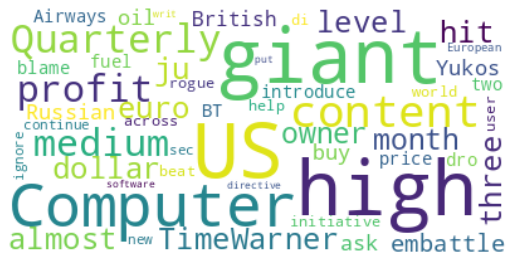

In [ ]:
# Las 50 palabras más comunes en las noticias preprocesadas
stopwords_wordcloud = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=60, max_words=50, 
                      background_color="white", random_state=100, 
                      stopwords=stopwords_wordcloud).generate(str(data['content_lemmatized']))
plt.figure(figsize=[9,9])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

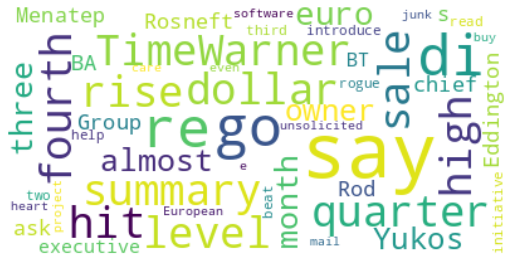

In [ ]:
# Las 50 palabras más comunes en los resúmenes preprocesados
stopwords_wordcloud = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=60, max_words=50, 
                      background_color="white", random_state=100, 
                      stopwords=stopwords_wordcloud).generate(str(data['summary_lemmatized']))
plt.figure(figsize=[9,9])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## **5. Preparación de Datos y Modelado**

### **5.1. Datos de Entrenamiento, Prueba y Validación**

In [ ]:
max_len = 1250
vocab_size = 10000

In [ ]:
train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))
test_size = len(data) - train_size - val_size

train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[-test_size:]

In [ ]:
train_text = train_data['content_lemmatized'].values
val_text = val_data['content_lemmatized'].values
test_text = test_data['content_lemmatized'].values

tokenizer = tokenize_text(train_text)
X_train = tokenizer.texts_to_sequences(train_text)
X_val = tokenizer.texts_to_sequences(val_text)
X_test = tokenizer.texts_to_sequences(test_text)

X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
X_val = pad_sequences(X_val, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

y_train = to_categorical(train_data['summary_lemmatized_len'].values, num_classes=max_len)
y_val = to_categorical(val_data['summary_lemmatized_len'].values, num_classes=max_len)
y_test = to_categorical(test_data['summary_lemmatized_len'].values, num_classes=max_len)

### **5.2. Modelado**

In [ ]:
# Función de creación del modelo
def create_model(max_len, vocab_size):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_len))
    model.add(Bidirectional(LSTM(128, kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))))
    model.add(Dropout(0.5))
    model.add(RepeatVector(max_len))
    model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))))
    model.add(TimeDistributed(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))))
    model.add(TimeDistributed(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
# Creación del modelo
batch_size = 64
epochs = 3

model = create_model(max_len, vocab_size)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1250, 100)         1000000   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 1250, 256)        0         
 )                                                               
                                                                 
 bidirectional_1 (Bidirectio  (None, 1250, 256)        394240    
 nal)                                                            
                                                        

In [ ]:
# Entrenamiento del modelo
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs, callbacks=[checkpoint])

Epoch 1/3
28/28 [==============================] - ETA: 0s - loss: 15.9565 - accuracy: 0.9633
Epoch 1: val_accuracy improved from -inf to 0.99920, saving model to best_model.h5
28/28 [==============================] - 26s 490ms/step - loss: 15.9565 - accuracy: 0.9633 - val_loss: 11.0169 - val_accuracy: 0.9992
Epoch 2/3
28/28 [==============================] - ETA: 0s - loss: 8.5764 - accuracy: 0.9992
Epoch 2: val_accuracy did not improve from 0.99920
28/28 [==============================] - 12s 440ms/step - loss: 8.5764 - accuracy: 0.9992 - val_loss: 6.6564 - val_accuracy: 0.9992
Epoch 3/3
28/28 [==============================] - ETA: 0s - loss: 5.7420 - accuracy: 0.9992
Epoch 3: val_accuracy did not improve from 0.99920
28/28 [==============================] - 11s 385ms/step - loss: 5.7420 - accuracy: 0.9992 - val_loss: 5.0144 - val_accuracy: 0.9992


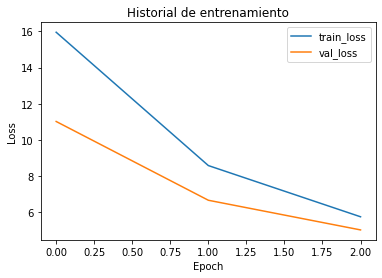

In [ ]:
# Gráfica Loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Historial de entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

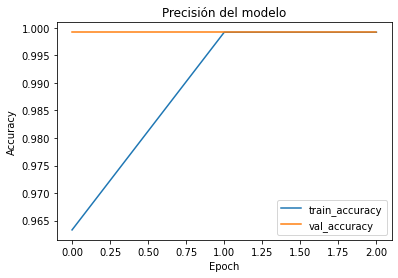

In [ ]:
# Gráfica Accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Precisión del modelo')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## **6. Model Inference**

### **6.1. Definición de funciones**

In [ ]:
# Función para recomendar el número de oraciones del resumen
def get_num_sentences(text, sent_per_100words):
    # Longitud del texto original
    text_len = len(text.split())

    # Número de oraciones en el resumen
    num_sentences = math.ceil((text_len / 100) * sent_per_100words)

    # Devolver el número de oraciones en el resumen
    return num_sentences

La función *get_num_sentences* calcula el número adecuado de oraciones para el resumen utilizando la longitud del texto original y el número deseado de oraciones por cada 100 palabras. En este caso, se asume que se desea utilizar tres oraciones por cada 100 palabras del texto original. El número de oraciones en el resumen se calcula utilizando la fórmula (texto_len / 100) * sent_per_100words y luego se redondea al número entero más cercano utilizando la función math.ceil.

In [ ]:
# Función de generación de resúmenes
def generate_summary(text, tokenizer, embed, model):
    text_stopwords_removed = remove_stopwords(text) 
    text_lemmatized = lemmatize_text(text_stopwords_removed)
    text_pos = pos_tag_text(text)
    num_sentences = get_num_sentences(text, 3)
    important_sents = important_sentences(text, embed, num_sentences)
    
    input_text = tokenizer.texts_to_sequences([text_lemmatized])
    input_text = pad_sequences(input_text, padding='post', maxlen=max_len)
    summary = model.predict(input_text)[0]
    
    summary_text = []
    for i in range(len(summary)):
        if summary[i] > 0.5:
            summary_text.append(text_pos[i][0])
    summary_text = ' '.join(summary_text)
    
    return important_sents + ' ' + summary_text

La función *generate_summary()* toma un texto de entrada y devuelve un resumen generado automáticamente. En el resumen se incluyen el número recomendado de las oraciones más importantes del texto original (determinadas mediante análisis de vectores de palabras) y las oraciones que el modelo considera importantes (las que tienen una probabilidad de ser relevantes superior a 0,5). La función utiliza varias subfunciones para eliminar palabras vacías, lematizar el texto, etiquetar partes del discurso y tokenizar el texto. Además, utiliza un modelo entrenado para clasificar oraciones como importantes o no importantes.

In [ ]:
# Función de evaluación de resúmenes
def evaluate_summary(original_text, summary):
    rouge = Rouge()
    scores = rouge.get_scores(summary, original_text)
    rouge_1_score = scores[0]["rouge-1"]["f"]
    rouge_2_score = scores[0]["rouge-2"]["f"]
    rouge_l_score = scores[0]["rouge-l"]["f"]
    avg_score = (rouge_1_score + rouge_2_score + rouge_l_score) / 3

    return rouge_1_score, rouge_2_score, rouge_l_score, avg_score

ROUGE (Recall-Oriented Understudy for Gisting Evaluation) es una métrica de evaluación de resumen automático que mide la similitud entre el resumen generado por una máquina y uno o varios resúmenes de referencia producidos por humanos. ROUGE se basa en la comparación de las secuencias de palabras de los resúmenes, y calcula diversas medidas de evaluación, como la precisión, el recall y el F1-score, para evaluar el desempeño del sistema de resumen automático.

ROUGE es ampliamente utilizado en la investigación de resumen automático y ha demostrado ser efectivo para comparar diferentes sistemas de resumen automático y para evaluar su desempeño en distintas tareas de resumen, como resumen de un solo documento, resumen de varios documentos y resumen de opinión.

La función *evaluate_summary* evalúa la calidad de un resumen generado comparándolo con el texto original utilizando la métrica ROUGE.

La función recibe dos parámetros: original_text, que es el texto original a partir del cual se generó el resumen, y summary, que es el resumen generado. Utiliza la librería rouge para calcular el valor de ROUGE-1, ROUGE-2, ROUGE-L y la media entre ellas, y los devuelve como una tupla de cuatro valores: rouge_1_score, rouge_2_score, rouge_l_score y avg_score.

* ROUGE-1, ROUGE-2 y ROUGE-L son medidas de evaluación automática de resúmenes que se utilizan para comparar un resumen generado automáticamente con un resumen de referencia o resumen humano.

* ROUGE-1 (Recall-Oriented Understudy for Gisting Evaluation) mide la similitud entre las palabras de unigramas (palabras individuales) del resumen generado y del resumen de referencia. Evalúa cuántas palabras del resumen de referencia se superponen con las palabras del resumen generado, dividido por el número total de palabras en el resumen de referencia.

* ROUGE-2 mide la similitud entre los bigramas (pares de palabras consecutivas) del resumen generado y del resumen de referencia. Evalúa cuántos pares de palabras del resumen de referencia se superponen con los pares de palabras del resumen generado, dividido por el número total de pares de palabras en el resumen de referencia.

* ROUGE-L mide la similitud de la secuencia más larga de palabras comunes entre el resumen generado y el resumen de referencia. Evalúa la longitud de la secuencia más larga de palabras comunes entre el resumen de referencia y el resumen generado, dividido por el número total de palabras en el resumen de referencia. ROUGE-L es útil para evaluar resúmenes que pueden estar reordenados o tener palabras adicionales o eliminadas.

Estos valores permiten cuantificar la calidad del resumen generado. Un valor alto indica que el resumen es muy similar al texto original y, por lo tanto, es de alta calidad.

### **6.1. Generación del resumen de una noticia**

In [ ]:
text = "En 2016, el programa de inteligencia artificial AlphaGo derrotó al campeón de Go Lee Sedol en un juego histórico. El enfrentamiento se llevó a cabo en Seúl, Corea del Sur, y fue visto por millones de personas en todo el mundo. AlphaGo, desarrollado por la compañía DeepMind de Google, utilizó técnicas de aprendizaje profundo para vencer a Sedol en cuatro de los cinco juegos. El éxito de AlphaGo fue un hito en el desarrollo de la inteligencia artificial y generó debates sobre su impacto en la sociedad y el futuro del trabajo humano. El juego de Go, un juego de estrategia chino de 2,500 años de antigüedad, se considera uno de los juegos de tablero más complejos del mundo. AlphaGo utilizó un enfoque novedoso para vencer a Sedol, utilizando una combinación de técnicas de aprendizaje profundo y búsqueda de árboles de Monte Carlo. A pesar de su derrota, Sedol se ganó el respeto de la comunidad del Go por su habilidad y dedicación al juego. Desde entonces, AlphaGo ha sido retirado de la competición, pero su éxito ha allanado el camino para el desarrollo de otras aplicaciones de inteligencia artificial en una variedad de campos."
summary = generate_summary(text, tokenizer, embed, model)
print("Texto original:\n", text)
print("Resumen generado:\n", summary)
print("\n")

rouge_1_score, rouge_2_score, rouge_l_score, avg_score = evaluate_summary(text, summary)
print("Puntuación ROUGE-1: ", rouge_1_score)
print("Puntuación ROUGE-2: ", rouge_2_score)
print("Puntuación ROUGE-L: ", rouge_l_score)
print("Puntuación media: ", avg_score)


1/1 [==============================] - 2s 2s/step
Texto original:
 En 2016, el programa de inteligencia artificial AlphaGo derrotó al campeón de Go Lee Sedol en un juego histórico. El enfrentamiento se llevó a cabo en Seúl, Corea del Sur, y fue visto por millones de personas en todo el mundo. AlphaGo, desarrollado por la compañía DeepMind de Google, utilizó técnicas de aprendizaje profundo para vencer a Sedol en cuatro de los cinco juegos. El éxito de AlphaGo fue un hito en el desarrollo de la inteligencia artificial y generó debates sobre su impacto en la sociedad y el futuro del trabajo humano. El juego de Go, un juego de estrategia chino de 2,500 años de antigüedad, se considera uno de los juegos de tablero más complejos del mundo. AlphaGo utilizó un enfoque novedoso para vencer a Sedol, utilizando una combinación de técnicas de aprendizaje profundo y búsqueda de árboles de Monte Carlo. A pesar de su derrota, Sedol se ganó el respeto de la comunidad del Go por su habilidad y dedicac

* *ROUGE-1*: esta puntuación mide la proporción de palabras en común entre el resumen generado y el texto original. Se calcula contando el número de palabras comunes en ambos textos y dividiéndolo por el número total de palabras en el texto original. En este caso, la puntuación ROUGE-1 es de 0.81, lo que indica que el resumen generado contiene el 81% de las palabras del texto original.

* *ROUGE-2*: esta puntuación mide la proporción de pares de palabras en común entre el resumen generado y el texto original. Se calcula contando el número de pares de palabras comunes en ambos textos y dividiéndolo por el número total de pares de palabras en el texto original. En este caso, la puntuación ROUGE-2 es de 0.75, lo que indica que el resumen generado contiene el 75% de los pares de palabras del texto original.

* *ROUGE-L*: esta puntuación mide la proporción de secuencias de palabras en común entre el resumen generado y el texto original, considerando el orden de las palabras. Se calcula utilizando la métrica de Longest Common Subsequence (LCS) entre ambos textos. En este caso, la puntuación ROUGE-L es de 0.81, lo que indica que el resumen generado contiene el 81% de las secuencias de palabras del texto original.

En general, las puntuaciones ROUGE indican que el resumen generado tiene una alta similitud con el texto original, lo que sugiere que la función generate_summary ha generado un resumen de alta calidad. La puntuación media de 0.79 indica que el resumen es bastante bueno en términos de contenido y coherencia.

### **6.2. Generación del resumen de varias noticias aleatorias**

In [ ]:
# Cargar el archivo EnglishDataset.csv
df = pd.read_csv('English Dataset.csv')

# Elegir 25 líneas al azar
random_indexes = random.sample(range(len(df)), 25)
sample_df = df.iloc[random_indexes]

# Iterar sobre las filas de la muestra y generar un resumen para cada una
for index, row in sample_df.iterrows():
    text = row['Text']
    text = text.split('. ', 1)[1]  # Eliminar la primera oración (encabezado)
    summary = generate_summary(text, tokenizer, embed, model)
    print("Texto original:\n", text)
    print("Resumen generado:\n", summary)
    print("\n")

    rouge_1_score, rouge_2_score, rouge_l_score, avg_score = evaluate_summary(text, summary)
    print("Puntuación ROUGE-1: ", rouge_1_score)
    print("Puntuación ROUGE-2: ", rouge_2_score)
    print("Puntuación ROUGE-L: ", rouge_l_score)
    print("Puntuación media: ", avg_score)
    print('-------------------------------------------------------------\n')

1/1 [==============================] - 0s 78ms/step
Texto original:
  fellow bath prop duncan bell will start on the bench  as coach andy robinson makes just one change to the team that was beaten by france. it will be stevens  first start after two caps as a replacement against the all blacks last year. leicester duo ollie smith and andy goode have been drafted onto the bench. stevens takes over from phil vickery  who suffered a broken arm playing for gloucester last weekend.  i m confident matt will grasp this opportunity and make his mark against ireland   said robinson.   all three players have shown outstanding form of late  most recently in the england a win against france a and for their club   added robinson.  selection beckons when players demonstrate such consistent ability.  this game against ireland will be massive. we recognise it s a must-win game for us this season.  england confirmed that sale sharks prop andrew sheridan was not considered for selection because of an in

## **7. Conclusiones y Recomendaciones**

### **7.1. Conclusiones**

Sobre la base de los resultados obtenidos se puede concluir que:
* El uso de técnicas de Natural Language Processing (NLP) y Machine Learning (ML) permiten generar resúmenes de noticias en inglés de manera automática a través del uso de una red neuronal.
* La implemenyación y uso de una arquitectura de red neuronal recurrente bidireccional (Bidirectional LSTM) es efectiva para la generación automática de los resúmenes de noticias en inglés.
* Los datos contenidos en el dataset *BBC News* son adecuados para el entrenamiento de la red neuronal.
* Se pueden aplicar métricas de evaluación para medir la calidad de los resúmenes generados automáticamente.
* Es posible aplicar el modelo entrenado a otras noticias fuera del dataset de entrenamiento, en este caso *English Dataset.csv*,lo que sugiere que el modelo pude generalizarse a otras noticias.

En general, los objetivos planteados se cumplieron exitosamente, lo que indica que la aplicación de técnicas de NLP y ML es efectiva para generar resúmenes automáticos de noticias en inglés.

### **7.2. Recomendaciones**

Tomando como punto de partida los objetivos y considerando que fueron conseguidos exitosamente, se pueden ralizar las siguientes recomendaciones:

* Considerar la ampliación del dataset para mejorar la diversidad de las noticias y la capacidad del modelo para generalizar a nuevas noticias.
* Si bien el modelo de red neuronal recurrente bidireccional utilizado en el proyecto fue exitoso, es recomendable explorar otros modelos y arquitecturas para ver si pueden producir resultados aún mejores.
* Aunque el proyecto se centra únicamente en la generación de resúmenes de noticias en inglés, podría ser recomendable extender el modelo a otros idiomas para poder generar resúmenes en diferentes lenguas.